# Engine Sizing
The followign overview gives an overview of sizing te engine given a certain thrust target and OF ratio.

In [172]:
# general
import os
import numpy as np

# thermo
import cantera as ct

# visualization / other
import matplotlib.pyplot as plt

In [173]:
plotfolder = "engineplots/"
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

### Main parameter definitions

In [174]:
P0 = 2.758e+6 # First Chamber (Stagnation) Pressure Guess [Pa]
P_amb = 101325 # Ambient Pressure [Pa] - optimal operating pressure
Ti = 300      # First Chamber Inlet Temperature Guess [K]
OF = 10.2     # OF ratio used
thrust = 4448.22 # Tqrget thrust [N]

In [175]:
# Define gas
gas = ct.Solution('gri30.yaml')          
mixture = "C2H6:1, N2O:{}".format(OF)    # define mixture via mixture string
gas.TPY = Ti, P0, mixture              # define state of gas before chemical balance
gas.equilibrate("HP")                  # equilibrate keeping enthalpy and pressure constant

# Extract Preliminary Gas Properties
h0 = gas.h  # gas enthalpy [J]
T0 = gas.T  # stagnation temperature [K]
kc = gas.cp / gas.cv # specific heat ratio in chamber
MW = gas.mean_molecular_weight / 1000.0 # average molecular weight of gas [kg / mol] (function returns [g / mol])
R = (ct.gas_constant / 1000.0) / MW # Specfic gas constant of exhaust gases [J / kg K] (ct.gas_constant returns [J / kmol K])

# Print Properties
print("Enthalpy:", h0, "[J]\nStagnation temperature:", T0, "[K]\nSpecific heat ratio:", kc, "[-]\nMean molecular weight:", MW, "[kg/mol]", "\nSpecific gas constant:", R, "[J/kg K]")

Enthalpy: 1441245.9601456434 [J]
Stagnation temperature: 3281.188239511196 [K]
Specific heat ratio: 1.2405024045277944 [-]
Mean molecular weight: 0.02620354167025899 [kg/mol] 
Specific gas constant: 317.3030089894356 [J/kg K]


## Engine Sizing
The main parameters for the engine to be sized are the throat area $A_t$ and the exit area $A_e$. The following sizing procedure uses the equation for thrust <em>(equation nr. 28 from equation sheet)</em> $F = \dot{m} c^* C_F$, where $c^*(k)$ is taken to be a constant (i.e. specific heat ratio - k is assumed to be constant throughout the thrust chamber) and $C_F(k, P_amb)$ is also taken to be a sort of constant to relate $\dot{m}$ to $F$. From this we find $\dot{m}$.<br>
Then we use $P_0 A_t = \dot{m} c^*$ <em>(equation nr. 25 from equation sheet)</em>, to find $A_t$ .


### Finding Throat Area $A_t$

In [176]:
# Defining equations for characteristic velocity and thrust coefficient 
def get_c_star(k, R, T0):
    return np.sqrt(k * R * T0) / (k * np.sqrt( (2 / (k + 1))**((k + 1)/(k - 1)) ) )
# k = specific heat ratio, R = specific gas constant, T0 = stagnation temperature

def get_C_F(k, R, T0, P_amb, P0):
    return np.sqrt(2 * k ** 2 / (k - 1) * (2 / (k + 1)) ** ((k + 1) / (k - 1)) * (1 - (P_amb / P0) ** ((k - 1) / k)))
# k = specific heat ratio, R = specific gas constant, T0 = stagnation temperature, P_amb = exit pressure, P0 = stagnation pressure

In [177]:
# Find characteristic velocity, thrust coefficient, and mass flow rate
c_star = get_c_star(kc, R, T0)
C_F = get_C_F(kc, R, T0, P_amb, P0)
mdot = thrust / (c_star * C_F)

print("Characteristic velocity:", c_star, "[m/s]\nThrust coefficient:", C_F, "[-]", "\nMass flow rate:", mdot, "[kg/s]")


Characteristic velocity: 1554.759568630687 [m/s]
Thrust coefficient: 1.449681880790852 [-] 
Mass flow rate: 1.973559886369499 [kg/s]


In [178]:
# Find throat area
A_t = mdot * c_star / (P0)

# print throat area
print("Throat area:", A_t * 10000, "[cm^2]")

Throat area: 11.12549353734108 [cm^2]


### Finding Exit Area $A_e$

In [179]:
""" Currently Placeholder """

' Currently Placeholder '

### Determining Other Operation Parameters
From the previous values we can obtain other operation parameters, such as specific impulse $I_{sp} = \frac{C_F * C^*}{g}$

In [180]:
Isp = C_F * c_star / 9.81
print("Specific impulse:", Isp, "[s]")

Specific impulse: 229.75604236800288 [s]


### Retrieving Chamber Geometry
Using the throat area $A_t$ and geometry parameters such as:
- $\alpha$ - divergence half angle
- $\beta$ - convergence half angle
- $Dc$ - chamber diameter

as well as theoretical parameters such as:

- $L^*$ - characteristic length

The chamber geometry retireving currently doesn't involve finding exit area, so we will use a manually set a total length $L_{tot}$, which will set a $divergence length $L_{div}$ - the axial lenght of the diverging section.

In [181]:
alpha = 15 # nozzle divergence half angle [deg]
beta =  30 # nozzle convergence half angle [deg]
D_c = 0.127 # chamber diameter [m]
L_star = 3 # characteristic length [m]
L_tot = 0.3 # divergence length [m]


In [182]:
# Calculate additional dimensional parameters
V_c = A_t * L_star # chamber volume [m^3]
A_c = np.pi * D_c ** 2 / 4 # chamber area [m^2]
D_t = np.sqrt(4 * A_t / np.pi) # throat diameter [m]

L_conv = (D_c - D_t) / np.tan(np.radians(beta)) # converging length [m]
L_cyl = V_c / A_c - L_conv * (1 + np.sqrt(A_t / A_c) + A_t / A_c) # cylindrical chamber length [m] (from equation 32 in equation sheet)
L_div = L_tot - L_conv # divergence length [m]

D_e = D_t + 2 * L_div * np.tan(np.radians(alpha)) # exit diameter [m]

# check if diameter dimension is physically possible
if(D_c - D_t < 0):
    print("Diameter dimension is not physically possible. Chamber diameter is by {} m smaller than throat diameter.".format(D_c - D_t))

# print dimensional parameters
print("Chamber volume:", V_c * 1e6, "[cm^3]\nChamber area:", A_c * 1e4, "[cm^2]\nThroat diameter:", D_t * 1e2, "[cm]\nConverging length:", L_conv * 1e2, "[cm]\nCylindrical chamber length:", L_cyl * 1e2, "[cm]", "\nDiverging length:", L_div * 1e2, "[cm]", "\nExit diameter:", D_e * 1e2, "[cm]")

Chamber volume: 3337.648061202324 [cm^3]
Chamber area: 126.67686977437444 [cm^2]
Throat diameter: 3.763697427588747 [cm]
Converging length: 15.478130087224748 [cm]
Cylindrical chamber length: 4.923214266061857 [cm] 
Diverging length: 14.521869912775252 [cm] 
Exit diameter: 11.54594405902464 [cm]


In [183]:
# Manually extracting geometry as a function of axial position r(x)
x = list()
r = list()

# first position - chamber start (injector plate)
x.append(0) 
r.append(D_c / 2) 

# second position - chamber end (converging section start)
x.append(L_cyl) 
r.append(D_c / 2) 

# third position - throat
x.append(L_cyl + L_conv)
r.append(D_t / 2)

# fourth position - diverging section end
x.append(L_cyl + L_conv + L_div)
r.append(D_e / 2)

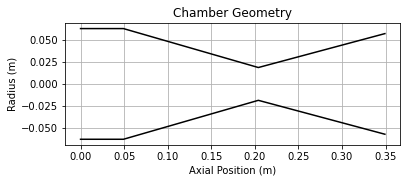

In [184]:
# plot result
fig, axs = plt.subplots()
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Chamber Geometry")
axs.set_aspect('equal')
plt.savefig(plotfolder + "enginegeometry.png", dpi=300)

### Determining Other Useful Parameters

In [185]:
o_mdot = mdot * OF / (OF + 1) # oxidizer mass flow rate [kg/s]
f_mdot = mdot / (OF + 1) # fuel mass flow rate [kg/s]
print("Oxidizer mass flow rate:", o_mdot, "[kg/s]\nFuel mass flow rate:", f_mdot, "[kg/s]")

Oxidizer mass flow rate: 1.7973491822293652 [kg/s]
Fuel mass flow rate: 0.17621070414013384 [kg/s]
